上篇文章初步介绍了各种中间价的计算方法，并给出了一种中间价的修订，本文继续深入这个话题。

### 所需数据

订单流数据和十档的深度数据，来自于实盘收集，更新频率都是100ms。实盘的只包含买一卖一盘口数据是实时更新的，为了简洁，暂时不用。考虑到数据太大，只保留了10万行深度数据，并且把逐档行情也独立为单独的列。

In [1]:
from datetime import date,datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
%matplotlib inline

In [2]:
tick_size = 0.0001

In [3]:
trades = pd.read_csv('YGGUSDT_aggTrade.csv',names=['type','event_time', 'agg_trade_id','symbol', 'price', 'quantity', 'first_trade_id', 'last_trade_id',
       'transact_time', 'is_buyer_maker'])

In [4]:
trades = trades.groupby(['transact_time','is_buyer_maker']).agg({
    'transact_time':'last',
    'agg_trade_id': 'last',
    'price': 'first',
    'quantity': 'sum',
    'first_trade_id': 'first',
    'last_trade_id': 'last',
    'is_buyer_maker': 'last',
})

In [5]:
trades.index = pd.to_datetime(trades['transact_time'], unit='ms')
trades.index.rename('time', inplace=True)
trades['interval'] = trades['transact_time'] - trades['transact_time'].shift()

In [6]:
depths = pd.read_csv('YGGUSDT_depth.csv',names=['type','event_time', 'transact_time','symbol', 'u1', 'u2', 'u3', 'bids','asks'])

In [7]:
depths = depths.iloc[:100000]

In [8]:
depths['bids'] = depths['bids'].apply(ast.literal_eval).copy()
depths['asks'] = depths['asks'].apply(ast.literal_eval).copy()

In [9]:
def expand_bid(bid_data):
    expanded = {}
    for j, (price, quantity) in enumerate(bid_data):
        expanded[f'bid_{j}_price'] = float(price)
        expanded[f'bid_{j}_quantity'] = float(quantity)
    return pd.Series(expanded)
def expand_ask(ask_data):
    expanded = {}
    for j, (price, quantity) in enumerate(ask_data):
        expanded[f'ask_{j}_price'] = float(price)
        expanded[f'ask_{j}_quantity'] = float(quantity)
    return pd.Series(expanded)
# 应用到每一行，得到新的df
expanded_df_bid = depths['bids'].apply(expand_bid)
expanded_df_ask = depths['asks'].apply(expand_ask)
# 在原有df上进行扩展
depths = pd.concat([depths, expanded_df_bid, expanded_df_ask], axis=1)

In [10]:
depths.index = pd.to_datetime(depths['transact_time'], unit='ms')
depths.index.rename('time', inplace=True);

In [11]:
trades = trades[trades['transact_time'] < depths['transact_time'].iloc[-1]]

先看下这20档档行情的分布，符合预期，距离盘口越远，一般挂单也多，且买单挂单和卖单挂单大致对称。

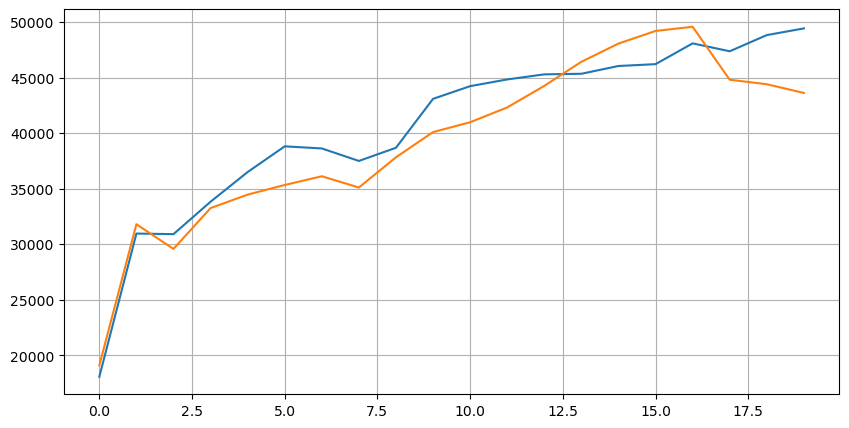

In [14]:
bid_mean_list = []
ask_mean_list = []
for i in range(20):
    bid_mean_list.append(round(depths[f'bid_{i}_quantity'].mean(),0))
    ask_mean_list.append(round(depths[f'ask_{i}_quantity'].mean(),0))
plt.figure(figsize=(10, 5))
plt.plot(bid_mean_list);
plt.plot(ask_mean_list);
plt.grid(True)

把深度数据和成交数据进行合并，方便评估预测的准确性。这里保证成交数据都是晚于深度数据，在不考虑延时的情况下,直接计算预测值与实际成交价的均方误差。用于衡量预测的准确度。

从结果来看，买一卖一平均值mid_price的误差最大，改为weight_mid_price后，误差立刻小了很多，用调整加权中间价又改进了一点。昨天的文章发出后，有人反馈只用I^3/2，这里检查了下，发现结果更好了。思考了下原因，应该是事件发生频率的不同，I在接近-1和1时是低概率事件，为了修正这些低概率，反而把高频率发生的事件预测的不那么精确了，因此，在更照顾高频率事件的情况下，我又调整了下(这里是纯粹的试出来的参数，实盘参考意义不大)：
$$P_{awm} =P_m +(P_a-P_b)\frac{(I+0.3)(I^4+0.7)}{3.8}$$
结果又稍好了一些。上篇文章说过，策略应该用跟多的数据来预测，在有了更多深度和订单成交数据的情况下，纠结与盘口能获得的提升已经很弱了。

In [15]:
df = pd.merge_asof(trades, depths, on='transact_time', direction='backward')

In [17]:
df['spread'] = round(df['ask_0_price'] - df['bid_0_price'],4)
df['mid_price'] = (df['bid_0_price']+ df['ask_0_price']) / 2
df['I'] = (df['bid_0_quantity'] - df['ask_0_quantity']) / (df['bid_0_quantity'] + df['ask_0_quantity'])
df['weight_mid_price'] = df['mid_price'] + df['spread']*df['I']/2
df['adjust_mid_price'] = df['mid_price'] + df['spread']*(df['I'])*(df['I']**8+1)/4
df['adjust_mid_price_2'] = df['mid_price'] + df['spread']*df['I']*(df['I']**2+1)/4
df['adjust_mid_price_3'] = df['mid_price'] + df['spread']*df['I']**3/2
df['adjust_mid_price_4'] = df['mid_price'] + df['spread']*(df['I']+0.3)*(df['I']**4+0.7)/3.8

In [18]:
print('平均值     mid_price的误差：', ((df['price']-df['mid_price'])**2).sum())
print('挂单量加权 mid_price的误差：', ((df['price']-df['weight_mid_price'])**2).sum())
print('调整后的   mid_price的误差：', ((df['price']-df['adjust_mid_price'])**2).sum())
print('调整后的 mid_price_2的误差：', ((df['price']-df['adjust_mid_price_2'])**2).sum())
print('调整后的 mid_price_3的误差：', ((df['price']-df['adjust_mid_price_3'])**2).sum())
print('调整后的 mid_price_4的误差：', ((df['price']-df['adjust_mid_price_4'])**2).sum())

平均值     mid_price的误差： 0.0048751924999999845
挂单量加权 mid_price的误差： 0.0048373440193987035
调整后的   mid_price的误差： 0.004803654771638586
调整后的 mid_price_2的误差： 0.004808216498329721
调整后的 mid_price_3的误差： 0.004794984755260528
调整后的 mid_price_4的误差： 0.0047909595497071375


### 考虑第二档深度

这里用上一篇的思路，考察某个影响参数的的不同取值范围，成交价的变化来衡量这个参数对中间价的贡献。如第一档深度的图，随着I的增加，成交价接下来成交价越可能正向变化，这说明I做了正的贡献。

第二档用同样的方式处理，发现虽然效应比第一档小了一些，但任然不容忽略。第三档深度也有微弱的贡献，但单调性差了很多，更深的深度基本没有参考价值了。

根据贡献程度不同，这三档的不平衡参数，分配了不同的权重，实际检查对于不同的计算方式，预测误差都进一步下降。

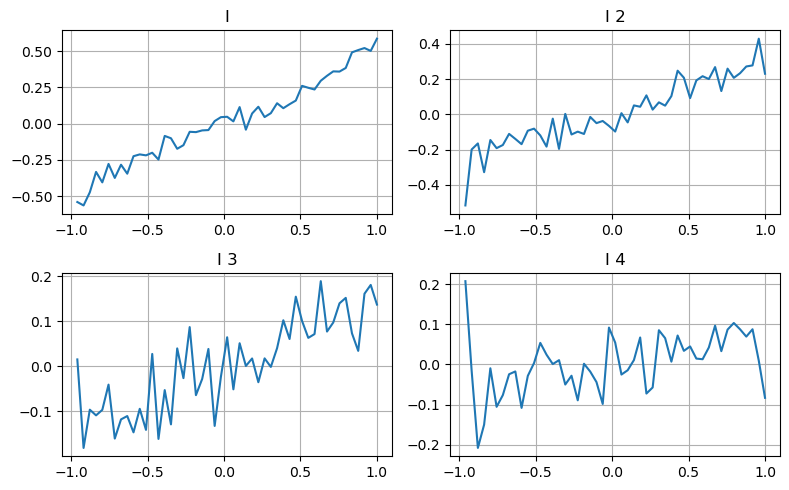

In [19]:
bins = np.linspace(-1, 1, 50)
df['change'] = (df['price'].pct_change().shift(-1))/tick_size
df['I_bins'] = pd.cut(df['I'], bins, labels=bins[1:])
df['I_2'] = (df['bid_1_quantity'] - df['ask_1_quantity']) / (df['bid_1_quantity'] + df['ask_1_quantity'])
df['I_2_bins'] = pd.cut(df['I_2'], bins, labels=bins[1:])
df['I_3'] = (df['bid_2_quantity'] - df['ask_2_quantity']) / (df['bid_2_quantity'] + df['ask_2_quantity'])
df['I_3_bins'] = pd.cut(df['I_3'], bins, labels=bins[1:])
df['I_4'] = (df['bid_3_quantity'] - df['ask_3_quantity']) / (df['bid_3_quantity'] + df['ask_3_quantity'])
df['I_4_bins'] = pd.cut(df['I_4'], bins, labels=bins[1:])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))


axes[0][0].plot(df.groupby('I_bins')['change'].mean())
axes[0][0].set_title('I')
axes[0][0].grid(True)

axes[0][1].plot(df.groupby('I_2_bins')['change'].mean())
axes[0][1].set_title('I 2')
axes[0][1].grid(True)

axes[1][0].plot(df.groupby('I_3_bins')['change'].mean())
axes[1][0].set_title('I 3')
axes[1][0].grid(True)

axes[1][1].plot(df.groupby('I_4_bins')['change'].mean())
axes[1][1].set_title('I 4')
axes[1][1].grid(True)
plt.tight_layout();

In [20]:
df['adjust_mid_price_4'] = df['mid_price'] + df['spread']*(df['I']+0.3)*(df['I']**4+0.7)/3.8
df['adjust_mid_price_5'] = df['mid_price'] + df['spread']*(0.7*df['I']+0.3*df['I_2'])/2
df['adjust_mid_price_6'] = df['mid_price'] + df['spread']*(0.7*df['I']+0.3*df['I_2'])**3/2
df['adjust_mid_price_7'] = df['mid_price'] + df['spread']*(0.7*df['I']+0.3*df['I_2']+0.3)*((0.7*df['I']+0.3*df['I_2'])**4+0.7)/3.8
df['adjust_mid_price_8'] = df['mid_price'] + df['spread']*(0.7*df['I']+0.2*df['I_2']+0.1*df['I_3']+0.3)*((0.7*df['I']+0.3*df['I_2']+0.1*df['I_3'])**4+0.7)/3.8

In [21]:
print('调整后的 mid_price_4的误差：', ((df['price']-df['adjust_mid_price_4'])**2).sum())
print('调整后的 mid_price_5的误差：', ((df['price']-df['adjust_mid_price_5'])**2).sum())
print('调整后的 mid_price_6的误差：', ((df['price']-df['adjust_mid_price_6'])**2).sum())
print('调整后的 mid_price_7的误差：', ((df['price']-df['adjust_mid_price_7'])**2).sum())
print('调整后的 mid_price_8的误差：', ((df['price']-df['adjust_mid_price_8'])**2).sum())

调整后的 mid_price_4的误差： 0.0047909595497071375
调整后的 mid_price_5的误差： 0.0047884350488318714
调整后的 mid_price_6的误差： 0.0047778319053133735
调整后的 mid_price_7的误差： 0.004773578540592192
调整后的 mid_price_8的误差： 0.004771415189297518


### 考虑成交数据

成交数据直接反映了多空的程度，毕竟这是真金白银参与的选择，而挂单的成本低很多，甚至还有故意挂单欺骗的情况。因此预测中间价，策略要重点考虑成交数据。

考虑到形式，定义订单平均到达数量不平衡VI，Vb,Vs分别表示买单和卖单的单位事件内平均数量。

$${VI}=\frac{V_b-V_s}{V_b+V_s}$$

结果发现短时间内的到达数量对价格变化预测最为显著，当VI处于(0.1-0.9)之间时，与价格负相关，而在区间之外反而与价格迅速的正相关。这提示着，当行情不极端时，以震荡为主，价格会均值回归，当极端行情出现时，如大量的买单压过卖单，此时会走出趋势。即使不考虑这些低概率情况，简单假设趋势和VI满足负的线性关系，对中间价的预测误差又大幅下降。式子中的a代表系数。

$$P_{awm} =P_m +(P_a-P_b)* {(-VI)}*a$$


In [22]:
alpha=0.1

In [23]:
df['avg_buy_interval'] = None
df['avg_sell_interval'] = None
df.loc[df['is_buyer_maker'] == True, 'avg_buy_interval'] = df[df['is_buyer_maker'] == True]['transact_time'].diff().ewm(alpha=alpha).mean()
df.loc[df['is_buyer_maker'] == False, 'avg_sell_interval'] = df[df['is_buyer_maker'] == False]['transact_time'].diff().ewm(alpha=alpha).mean()

In [24]:
df['avg_buy_quantity'] = None
df['avg_sell_quantity'] = None
df.loc[df['is_buyer_maker'] == True, 'avg_buy_quantity'] = df[df['is_buyer_maker'] == True]['quantity'].ewm(alpha=alpha).mean()
df.loc[df['is_buyer_maker'] == False, 'avg_sell_quantity'] = df[df['is_buyer_maker'] == False]['quantity'].ewm(alpha=alpha).mean()

In [25]:
df['avg_buy_quantity'] = df['avg_buy_quantity'].fillna(method='ffill')
df['avg_sell_quantity'] = df['avg_sell_quantity'].fillna(method='ffill')
df['avg_buy_interval'] = df['avg_buy_interval'].fillna(method='ffill')
df['avg_sell_interval'] = df['avg_sell_interval'].fillna(method='ffill')

df['avg_buy_rate'] = 1000 / df['avg_buy_interval']
df['avg_sell_rate'] =1000 / df['avg_sell_interval']

df['avg_buy_volume'] = df['avg_buy_rate']*df['avg_buy_quantity']
df['avg_sell_volume'] = df['avg_sell_rate']*df['avg_sell_quantity']

In [26]:
df['I'] = (df['bid_0_quantity']- df['ask_0_quantity']) / (df['bid_0_quantity'] + df['ask_0_quantity'])
df['OI'] = (df['avg_buy_rate']-df['avg_sell_rate']) / (df['avg_buy_rate'] + df['avg_sell_rate'])
df['QI'] = (df['avg_buy_quantity']-df['avg_sell_quantity']) / (df['avg_buy_quantity'] + df['avg_sell_quantity'])
df['VI'] = (df['avg_buy_volume']-df['avg_sell_volume']) / (df['avg_buy_volume'] + df['avg_sell_volume'])

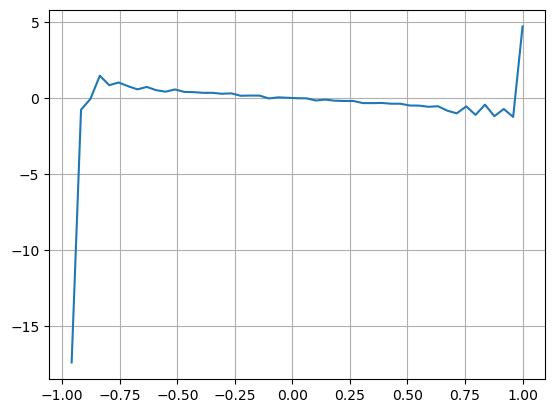

In [27]:
bins = np.linspace(-1, 1, 50)
df['VI_bins'] = pd.cut(df['VI'], bins, labels=bins[1:])
plt.plot(df.groupby('VI_bins')['change'].mean());
plt.grid(True)

In [28]:
df['adjust_mid_price'] = df['mid_price'] + df['spread']*df['I']/2
df['adjust_mid_price_9'] = df['mid_price'] + df['spread']*(-df['OI'])*2
df['adjust_mid_price_10'] = df['mid_price'] + df['spread']*(-df['VI'])*1.4

In [29]:
print('调整后的mid_price   的误差：', ((df['price']-df['adjust_mid_price'])**2).sum())
print('调整后的mid_price_9 的误差：', ((df['price']-df['adjust_mid_price_9'])**2).sum())
print('调整后的mid_price_10的误差：', ((df['price']-df['adjust_mid_price_10'])**2).sum())

调整后的mid_price   的误差： 0.0048373440193987035
调整后的mid_price_9 的误差： 0.004629586542840461
调整后的mid_price_10的误差： 0.004401790287167206


### 综合的中间价

考虑到挂单量和成交数据都对中间价的预测有帮助，因此可以把这两个参数合并在一起，这里权重的赋值比较随意，也没有考虑边界的条件，极端情况下，预测的中间价可能不在买一和卖一之间，但只要误差能够减小，也不在意这些细节了。

最后预测的误差从最开始的0.00487降到了0.0043，到这里就不继续深入了，中间价可挖掘的内容还有很多，毕竟预测中间价就是在预测价格，大家可以自己尝试。

In [30]:
#注意VI需要延后一个使用
df['CI'] = -1.5*df['VI'].shift()+0.7*(0.7*df['I']+0.2*df['I_2']+0.1*df['I_3'])**3 

In [31]:
df['adjust_mid_price_11'] = df['mid_price'] + df['spread']*(df['CI'])
print('调整后的mid_price_11的误差：', ((df['price']-df['adjust_mid_price_11'])**2).sum())

调整后的mid_price_11的误差： 0.0043001941412563575


### 总结

本文结合深度数据和成交数据，进一步改进了中间价的计算方法，本给出了衡量准确性的方法，提高了对价格变化预测的准确性。整体上各种参数都不太严谨，仅供参考。有了较为精确的中间价，接下来就是实际应用中间价进行回测了，这一部分内容也很多，先暂停一段时间更新。